In [1]:
import pandas as pd
import json
import numpy as np
import seaborn as sns
import scipy as sci
import matplotlib.pyplot as plt
import math
import time
import sys, os, base64, hashlib, hmac 
import requests
import urllib
from datetime import datetime
from datetime import timedelta
import warnings
warnings.filterwarnings("ignore")
import errno


In [2]:
#pd.set_option('display.max_columns', None)

In [3]:
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [4]:
def renameVoyages(df: pd.DataFrame):
    v = df.voyageid.unique()
    k = ["v" + str(x) for x in range(0,len(df.voyageid.unique()))]
    res = {v[i]: k[i] for i in range(len(v))}
    df['voyageid'] = df['voyageid'].replace(res)

# calculate 360 bearing from 180 bearing
def recalibrate_bearing(df: pd.DataFrame):
    for index, info in df.iterrows():
        bearing_180 = info['bearing']
        if (bearing_180 < 0):
            bearing_360 = 360 + bearing_180
            df.at[index, 'bearing_360'] = bearing_360
        else:
            df.at[index, 'bearing_360'] = bearing_180
            
def calculate_speed_over_water(speed_over_ground, ship_heading_in_degrees, ocean_current_speed, ocean_current_direction_in_degrees):
    angle_of_attack = calculate_angle_of_attack(ship_heading_in_degrees, ocean_current_direction_in_degrees)
    angle_of_attack_in_radians = convert_degree_to_radians(angle_of_attack)
    speed_over_water = speed_over_ground + ocean_current_speed*math.cos(angle_of_attack_in_radians)
    return speed_over_water

def calculate_angle_of_attack(ship_heading_in_degrees,direction_of_force_in_degrees):
    if(abs(ship_heading_in_degrees-direction_of_force_in_degrees) > 180):
        return 360-abs(ship_heading_in_degrees-direction_of_force_in_degrees)
    else:
        return abs(ship_heading_in_degrees-direction_of_force_in_degrees)

def convert_degree_to_radians(degree):
    return degree/57.2957795131

def speed_in_mps(df: pd.DataFrame):
    for index, info in df.iterrows():
        df.at[index, 'averagespeedongroundinmps'] = info['averagespeedongroundinknots']/1.944
    
    for index, info in df.iterrows():
        speed_over_ground = info['averagespeedongroundinmps']
        ship_heading_in_degrees = info['bearing_360']
        ocean_current_speed = info['oceancurrentspeed']
        ocean_current_direction_in_degrees = info['oceancurrentdirection']

        df.at[index, 'averagespeedonwaterinmps'] = calculate_speed_over_water(speed_over_ground, 
                                                                              ship_heading_in_degrees, 
                                                                              ocean_current_speed,
                                                                              ocean_current_direction_in_degrees)
    for index, info in df.iterrows():
        df.at[index, 'averagespeedonwaterinknots'] =  1.944 * info['averagespeedonwaterinmps']

def deg2rad(deg): return deg * (math.pi/180)
def rad2deg(rad): return rad * (180/math.pi)

def angle_between_two_angles(angle1, angle2):
    a = angle1 - angle2
    a = (a + 180) % 360 - 180
    return abs(a)

def windvelocity(df):
    for index, info in df.iterrows():
        bearing = info['bearing_360']
        #averagespeedongroundinmps = info['averagespeedongroundinmps']
        winddirection = info['winddirection']
        windspeedinmps = info['windspeedinmps']
        
        Alpha = angle_between_two_angles(bearing, winddirection)
        
        if Alpha < 90:
            windvelocity = -(windspeedinmps * math.cos(deg2rad(Alpha)))
            df.at[index,'windvelocity'] = windvelocity
        #else winddirection is outside of +- 90 deg from ship bearing
        #this will indicate negative wind velocity (resisting the ship)
        else:
            #obtain opposite angle
            Alpha = (Alpha+180)%360
            #this will indicate positive wind velocity (aiding the ship)
            windvelocity = (windspeedinmps * math.cos(deg2rad(Alpha)))
            df.at[index,'windvelocity'] = windvelocity
            
            
def wavevelocity(df):
    for index, info in df.iterrows():
        bearing = info['bearing_360']
        wavedirection = info['wavedirection']
        waveheight = info['waveheightinmeters']
        Alpha = angle_between_two_angles(bearing, wavedirection)
        if Alpha < 90:
            wavevelocity = -(waveheight * math.cos(deg2rad(Alpha)))
            df.at[index, 'wavevelocity'] = wavevelocity
        else:
            Alpha = (Alpha+180)%360
            wavevelocity = (waveheight * math.cos(deg2rad(Alpha)))
            df.at[index, 'wavevelocity'] = wavevelocity
    
def mpsToKnot(df):
    for index, info in df.iterrows():
        speed_in_mps = info['averagespeedonwaterinmps']
        df.at[index, 'averagespeedonwaterinknots'] = speed_in_mps * 1.94384

In [5]:
def sign(key, msg):
    return hmac.new(key, msg.encode('utf-8'), hashlib.sha256).digest()

def getSignatureKey(key, dateStamp, regionName, serviceName):
    kDate = sign(('AWS4' + key).encode('utf-8'), dateStamp)
    kRegion = sign(kDate, regionName)
    kService = sign(kRegion, serviceName)
    kSigning = sign(kService, 'aws4_request')
    return kSigning
def constructRequest(service,host,region,request_parameters,endpoint,canonical_uri,access_key,secret_key):
    print(endpoint+'?'+request_parameters)
    
    amzdt = datetime.utcnow()
    amzdate = amzdt.strftime('%Y%m%dT%H%M%SZ')
    canonical_headers = 'host:' + host + '\n' + 'x-amz-date:' + amzdate + '\n'
    datestamp = amzdt.strftime('%Y%m%d')
    credential_scope = datestamp + '/' + region + '/' + service + '/' + 'aws4_request'
    canonical_querystring = request_parameters
    canonical_request = method + '\n' + canonical_uri + '\n' + canonical_querystring + '\n' + canonical_headers + '\n' + signed_headers + '\n' + payload_hash
    string_to_sign = algorithm + '\n' +  amzdate + '\n' +  credential_scope + '\n' +  hashlib.sha256(canonical_request.encode('utf-8')).hexdigest()
    
    signing_key = getSignatureKey(secret_key, datestamp, region, service)
    signature = hmac.new(signing_key, (string_to_sign).encode('utf-8'), hashlib.sha256).hexdigest()
    authorization_header = algorithm + ' ' + 'Credential=' + access_key + '/' + credential_scope + ', ' +  'SignedHeaders=' + signed_headers + ', ' + 'Signature=' + signature
    headers = {'x-amz-date':amzdate, 'Authorization':authorization_header}
   
    request_url = endpoint + '?' + canonical_querystring
    #print(authorization_header)
    response_obj = requests.get(request_url, headers=headers)
    return response_obj

In [6]:
method = 'GET'
service = 'execute-api'
region = 'us-east-1'
signed_headers = 'host;x-amz-date'
algorithm = 'AWS4-HMAC-SHA256'

access_key = ''
secret_key = ''   
host = 'https://add_your_server_ip'
payload_hash = hashlib.sha256(('').encode('utf-8')).hexdigest()
request_parameters =''



detail_dict={'PARTICULARS':'particularsparameters','DESIGN':'shipdesigndata','WIND RESISTANCE':'windresistance',
                    'SEA TRIAL':'seatrialdata','SHOP TRIAL':'shoptrialreport','SHIP INFO':'shipinfodetails','HYDRO STATIC':'hydrostaticdata',
                    'POWER':'powerdata','LCV':'lcvcorrecteddata','SFOC':'shipfueloilconsumption','AIR RESISTANCE':'airresistancedataparameters',
                    'DESIGN EFFICIENCY':'designefficiency'}
def get_ship_data(detail_key,vessel_id,environment):
    detail = detail_dict[detail_key]
    ship_metadata_url = 'https://add_your_server_ip'+str(vessel_id)+'/metadata/'+detail
    canonical_uri='/prod/ship/'+str(vessel_id)+'/metadata/'+detail
    #print(ship_metadata_url)
    host='https://add_your_server_ip'
    metadata_response = constructRequest(service,host,region,request_parameters,ship_metadata_url,canonical_uri,access_key,secret_key)
    #print(metadata_response.text)
    ship_data = json.loads(metadata_response.text)
    return ship_data


def retro_dictify(frame):
    d = {}
    for row in frame.values:
        here = d
        for elem in row[:-2]:
            if elem not in here:
                here[elem] = {}
            here = here[elem]
        here[row[-2]] = row[-1]
    return d
def clean_and_typecast_df(df,columns_to_typecast,non_zero_column=None):
    for column in columns_to_typecast:
        df[column]=pd.to_numeric(df[column])
    df = df.dropna()
    if(non_zero_column is not None):
        df=df[df[non_zero_column]>0]
    return df
def get_correction_percent_v1(input_val,value_list):
    sorted_vals_high = sorted([i for i in value_list if i > input_val])
    sorted_vals_low = sorted([i for i in value_list if i <= input_val],reverse=True)

    if(len(sorted_vals_high)>0):
        high_val = sorted_vals_high[0]
        if(len(sorted_vals_high)>1):
            higher_val = sorted_vals_high[1]
        else:
            higher_val = 0
    else:
        high_val = 0
        higher_val = 0

    if(len(sorted_vals_low)>0):
        low_val = sorted_vals_low[0]
        if(len(sorted_vals_low)>1):
            lower_val = sorted_vals_low[1]
        else:
            lower_val = 0
    else:
        low_val = 0
        lower_val = 0

    max_val=None
    min_val=None
    if(high_val==0):
        max_val=low_val
    elif(low_val==0):
        max_val=higher_val
    else:
        max_val=high_val

    if(low_val==0):
        min_val=high_val
    elif(high_val==0):
        min_val=lower_val
    else:
        min_val=low_val
    if(max_val == min_val):
        correction_percent = 0
    else:
        correction_percent = (input_val-min_val)/(max_val-min_val)
    output_dict={}
    output_dict['MaxVal']=max_val
    output_dict['MinVal']=min_val
    output_dict['CorrectionPercent']=correction_percent
    return output_dict
def calculate_sfoc_val_kgpkwphr(power_required,shop_trial_df_mcr_percent_list,shop_trial_dict): # specifc fuel oil consumpt
    power_required_correction_data = get_correction_percent_v1(power_required,shop_trial_df_mcr_percent_list)

    lv_pr = power_required_correction_data['MinVal']
    hv_pr = power_required_correction_data['MaxVal']
    cp_pr = power_required_correction_data['CorrectionPercent']    
    SFOCValueKgPKWPHr = shop_trial_dict[lv_pr]+cp_pr*(shop_trial_dict[hv_pr]-shop_trial_dict[lv_pr])
    #print("SFOC Value Per KG per KW per Hr:"+str(SFOCValueKgPKWPHr))
    return SFOCValueKgPKWPHr

def get_shop_trial_details(vessel_id,environment):
    shop_trial_data = get_ship_data('SHOP TRIAL',vessel_id,environment)
    ship_particulars = get_ship_data('PARTICULARS',vessel_id,environment)
    lcv_standard = float(ship_particulars['shipParticularsData']['lcvStandard'])
    lcv_fuel_shop_trial = float(shop_trial_data['resultData']['lcvFuelShopTrial'])
    shop_trial_df = pd.DataFrame(shop_trial_data['resultData']['shopTrialLoad'])
    shop_trial_df = clean_and_typecast_df(shop_trial_df,['SFOCValue','percentage','MCRPercentageValue'],'SFOCValue')
    shop_trial_df['SFOCValueKgPKWPHr'] = (shop_trial_df['SFOCValue']/1000)*lcv_fuel_shop_trial/lcv_standard
    shop_trial_df_mcr_percent_list = list(shop_trial_df['MCRPercentageValue'])
    temp_shop_trial_df = shop_trial_df.copy()
    del temp_shop_trial_df['SFOCValue']
    del temp_shop_trial_df['percentage']
    shop_trial_dict = retro_dictify(temp_shop_trial_df)
    
    power_95 = ship_particulars['shipParticularsData']['mcr']['mcrvalue']
    #print(ship_particulars)
    #print("mcr value(power at 95%): " + power_95)
    power_05 = (float(power_95)/0.95) * 0.05
    #print("mcr value(power at 5%): " + str(power_05))
    
    return shop_trial_df_mcr_percent_list,shop_trial_dict, power_05

In [7]:
# vessel_id=9735050
# environment='prod'
# shop_trial_df_mcr_percent_list,shop_trial_dict = get_shop_trial_details(vessel_id,environment)
# power_data = get_ship_data('POWER',vessel_id,environment)
# fuel_oil_correction_factor = 1.15
# time_taken_in_seconds = 3*60*60

# BF = "BF1" # wind scale
# disp = 'scantling'
# index = 0

# print(power_data['resultData'][BF][disp])
# print()
# print("Wind Scale: " + BF)
# print("Displacement: " + disp)
# print()

# for i in power_data['resultData'][BF][disp]:
#     power_at_bf5_speed_18_design = power_data['resultData'][BF][disp][index]['totalPower']
#     sfoc_value_kgpkwphr = calculate_sfoc_val_kgpkwphr(power_at_bf5_speed_18_design,shop_trial_df_mcr_percent_list,shop_trial_dict)
#     foc = power_at_bf5_speed_18_design * sfoc_value_kgpkwphr * fuel_oil_correction_factor * time_taken_in_seconds/(3600*1000)
#     print(power_data['resultData'][BF][disp][index]['speed'])
#     print(foc)
#     index += 1

In [8]:
def displayFOC():
    vessels = [9735050, 9746695, 9788564, 9792515, 9796585, 9803364]
    environment = 'prod'
    
    for vessel_id in vessels:
        shop_trial_df_mcr_percent_list,shop_trial_dict, min_power = get_shop_trial_details(vessel_id,environment)
        power_data = get_ship_data('POWER',vessel_id,environment)
        fuel_oil_correction_factor = 1.15
        time_taken_in_seconds = 3*60*60
        
        BFs = ['BF1', 'BF2', 'BF3', 'BF4', 'BF5']
        disps = ['ballast','design','scantling']
        
        print("Vessel:", vessel_id)
        
        min_sfoc_value_kgpkwphr = calculate_sfoc_val_kgpkwphr(min_power,shop_trial_df_mcr_percent_list,shop_trial_dict)
        min_foc = min_power * min_sfoc_value_kgpkwphr * fuel_oil_correction_factor * time_taken_in_seconds/(3600*1000)
        print("Min FOC: " + str(min_foc))
        
        for BF in BFs:
            for disp in disps:
                #print(power_data['resultData'][BF][disp]) ##this prints json stuff
                print()
                print("Wind Scale: " + BF)
                print("Displacement: " + disp)
                print("Speed | Fuel Consumption")
                print()
                index = 0
                for i in power_data['resultData'][BF][disp]:
                    power_at_bf5_speed_18_design = power_data['resultData'][BF][disp][index]['totalPower']
                    sfoc_value_kgpkwphr = calculate_sfoc_val_kgpkwphr(power_at_bf5_speed_18_design,shop_trial_df_mcr_percent_list,shop_trial_dict)
                    foc = power_at_bf5_speed_18_design * sfoc_value_kgpkwphr * fuel_oil_correction_factor * time_taken_in_seconds/(3600*1000)
                    print(power_data['resultData'][BF][disp][index]['speed'], end = " ")
                    print(foc)
                    index += 1

In [9]:
#displayFOC()

In [10]:
def displayFOC2():
    #vessels = [9735050, 9746695, 9788564, 9792515, 9796585, 9803364]
    vessels = [9370537, 9399090, 9552824, 9552824, 9558294, 9610119]
    environment = 'prod'
    
    ship_collection = []
    
    for vessel_id in vessels:
        shop_trial_df_mcr_percent_list,shop_trial_dict, min_power = get_shop_trial_details(vessel_id,environment)
        power_data = get_ship_data('POWER',vessel_id,environment)
        fuel_oil_correction_factor = 1.15
        time_taken_in_seconds = 3*60*60
        
        BFs = ['BF1', 'BF2', 'BF3', 'BF4', 'BF5']
        disps = ['ballast','design','scantling']
        
        #print("Vessel:", vessel_id)
             
        min_sfoc_value_kgpkwphr = calculate_sfoc_val_kgpkwphr(min_power,shop_trial_df_mcr_percent_list,shop_trial_dict)
        min_foc = min_power * min_sfoc_value_kgpkwphr * fuel_oil_correction_factor * time_taken_in_seconds/(3600*1000)
        #print("Min FOC: " + str(min_foc))
        
        for BF in BFs:
            for disp in disps:
                #print(power_data['resultData'][BF][disp]) ##this prints json stuff
#                 print()
#                 print("Wind Scale: " + BF)
#                 print("Displacement: " + disp)
#                 print("Speed | Fuel Consumption")
#                 print()
                
                
                vessel_info = {
                    "Vessel": vessel_id,
                    "Min FOC": min_foc,
                    "Wind Scale": BF,
                    "Displacement": disp,
                    "Power": {},
                    "Power15up": {},
                    "Power15down": {}
                }
                
                
                index = 0
                for i in power_data['resultData'][BF][disp]:
                    power_at_bf5_speed_18_design = power_data['resultData'][BF][disp][index]['totalPower']
                    sfoc_value_kgpkwphr = calculate_sfoc_val_kgpkwphr(power_at_bf5_speed_18_design,shop_trial_df_mcr_percent_list,shop_trial_dict)
                    foc = power_at_bf5_speed_18_design * sfoc_value_kgpkwphr * fuel_oil_correction_factor * time_taken_in_seconds/(3600*1000)
#                     print(power_data['resultData'][BF][disp][index]['speed'], end = " ")
#                     print(foc)
                    
                    speed_value = power_data['resultData'][BF][disp][index]['speed']
                    if speed_value!=0 and speed_value!='':
                        vessel_info["Power"].update({speed_value : foc})
                        vessel_info["Power15up"].update({speed_value : foc*1.15})
                        vessel_info["Power15down"].update({speed_value : foc*0.85})
                    index += 1
                
                #print(vessel_info)
                ship_collection.append(vessel_info)
    return ship_collection

In [11]:
XX = displayFOC2()

https://hkm1h4pc2c.execute-api.us-east-1.amazonaws.com/prod/ship/9370537/metadata/shoptrialreport?
https://hkm1h4pc2c.execute-api.us-east-1.amazonaws.com/prod/ship/9370537/metadata/particularsparameters?
https://hkm1h4pc2c.execute-api.us-east-1.amazonaws.com/prod/ship/9370537/metadata/powerdata?
https://hkm1h4pc2c.execute-api.us-east-1.amazonaws.com/prod/ship/9399090/metadata/shoptrialreport?
https://hkm1h4pc2c.execute-api.us-east-1.amazonaws.com/prod/ship/9399090/metadata/particularsparameters?
https://hkm1h4pc2c.execute-api.us-east-1.amazonaws.com/prod/ship/9399090/metadata/powerdata?
https://hkm1h4pc2c.execute-api.us-east-1.amazonaws.com/prod/ship/9552824/metadata/shoptrialreport?
https://hkm1h4pc2c.execute-api.us-east-1.amazonaws.com/prod/ship/9552824/metadata/particularsparameters?
https://hkm1h4pc2c.execute-api.us-east-1.amazonaws.com/prod/ship/9552824/metadata/powerdata?
https://hkm1h4pc2c.execute-api.us-east-1.amazonaws.com/prod/ship/9552824/metadata/shoptrialreport?
https://hk

In [12]:
print(XX[1])

{'Vessel': 9370537, 'Min FOC': 0.5636076458933519, 'Wind Scale': 'BF1', 'Displacement': 'design', 'Power': {'13': 3.4052133247069, '14': 4.12955418114294, '15': 4.9780495139500625, '16': 5.930264457256249, '17': 7.109112763777643, '18': 8.776092369780207}, 'Power15up': {'13': 3.9159953234129343, '14': 4.748987308314381, '15': 5.724756941042571, '16': 6.819804125844686, '17': 8.175479678344288, '18': 10.092506225247236}, 'Power15down': {'13': 2.894431326000865, '14': 3.510121053971499, '15': 4.231342086857553, '16': 5.040724788667812, '17': 6.042745849210996, '18': 7.459678514313175}}


In [13]:
def plotter2(v):
    print()
    print('------------------------')
    print()
    speed_list = np.array([e for e in v['Power'] if e!=0])
    displacement_list = np.array([v['Power'][s] for s in speed_list])
    
    speed_list = np.insert(speed_list, 0, '5', axis=0).astype('float64')
    displacement_list = np.insert(displacement_list, 0 ,v['Min FOC'])
    
    plt.scatter(speed_list, displacement_list, marker='o') # markers for API data = o
    plt.xlabel('speedinwaterinKNOTS')
    plt.ylabel('FOC')
    
    def monoExp(x, m, t, b):
        return m * np.exp(t * x) + b

    params, cv = sci.optimize.curve_fit(monoExp, speed_list, displacement_list) #scipy package
    m, t, b = params
    
    print(m, t, b)
    x_out = list(range(5,21))
    y_pred = []
    y_pred_lower = []
    y_pred_upper = []
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    for i in range(5,21): # use the power and multiply by 15% tolerance then calculate new FOC from the power
        pred_value = monoExp(i, m, t, b)
        y_pred.append(pred_value)
        y_pred_lower.append(pred_value*0.85)
        y_pred_upper.append(pred_value*1.15)

    plt.plot(x_out, y_pred, label='extrapolated data from API', marker='x') # markers for extrapolated data = x
    plt.fill_between(x_out, y_pred_lower, y_pred_upper, color='y', alpha=0.2, label='error margin')
    plt.title(v['Wind Scale'] + " " + str(v['Vessel']) + " " + str(v['Displacement']))
    
    # read in vessel to plot datapoints 
    vessel_id = str(v['Vessel'])
    disp = str(v['Displacement'])
    windscale = int(v['Wind Scale'][-1])
    

    df  = pd.read_csv('C:/Users/hengj/Downloads/training_data/'+vessel_id+'_complete.csv')
    
    df = df.drop(df[df.bearing == '#DIV/0!'].index)
    df = df.drop(df[df.fuelconsumedbymainengineintons >= 20].index)
    df = df.drop(df[df.fuelconsumedbymainengineintons <= 0].index)
    df = df.dropna()
    df["bearing"] = df["bearing"] .astype(float)
    
    renameVoyages(df)
    recalibrate_bearing(df)
    speed_in_mps(df)
    windvelocity(df)
    wavevelocity(df)
    mpsToKnot(df)
    
    # filter for windscale and disp required 
    df = df[df[disp] == 1]
    df = df[df['windforce'] == windscale]
    df = df.drop(df[df.averagespeedonwaterinknots >= 40].index)

    df = removeError(m,t,b, df) ### check if points fall within tolerance (ADD DF AFTER THIS LINE)
    min_x = list(range(0,6))
    min_y = np.linspace(v['Min FOC'], v['Min FOC'], 6)
    print("Min FOC: " + str(v['Min FOC']))
    plt.plot(min_x, min_y, label='min FOC')
    plt.fill_between(range(0,6), min_y*0.8, min_y*1.20, color='y', alpha=0.2)
    plt.scatter(df['averagespeedonwaterinknots'], df['fuelconsumedbymainengineintons'], label="points from dataset")

    plt.legend(loc='best')
    plt.show()
    return df

def autoplotter(l):
    
    count = 0
    for e in l:
        accepted_df = plotter2(e)
        count+=1
        
        if (count == 1):
            df = accepted_df
        else:
            df = df.append(accepted_df)
        
    print("No of elements in dict: ", len(l))        
    print("Elements plotted: ", count)
    return df

In [14]:
def removeError(m,t,b,df): #m,t,b values for the exponential eqn, x value to check if inside equation band
    
    total_datapoints = len(df.index)
    accepted = 0
    
    for index, info in df.iterrows():
        actual_FOC = info['fuelconsumedbymainengineintons']
        actual_speed_knots = info['averagespeedonwaterinknots']
        pred_FOC =  m * np.exp(t * actual_speed_knots) + b # exponential eqn for pred FOC given speed in knots
        upper_margin = pred_FOC * 1.20
        lower_margin = pred_FOC * 0.80
        if (lower_margin <= actual_FOC <= upper_margin):   # check if actual FOC fall within error margins for FOC
            accepted += 1
            df.at[index, 'accepted'] = 1
        else:
            df.at[index, 'accepted'] = 0
            
    print("total datapoints: " + str(total_datapoints))
    print("accepted datapoints: "+ str(accepted)) 
    
    if (len(df.index) != 0): 
        df = df.drop(df[df.accepted == 0].index)
    return df
        


------------------------

0.40944554355527824 0.16639896653250263 -0.3841524645131253
total datapoints: 3
accepted datapoints: 1
Min FOC: 0.5636076458933519


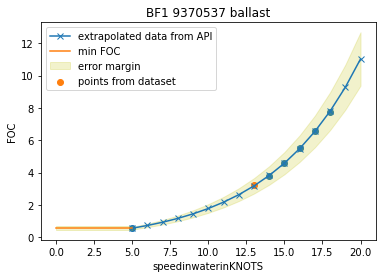


------------------------

0.35459341189292515 0.17955821063929145 -0.2886340300582273
total datapoints: 0
accepted datapoints: 0
Min FOC: 0.5636076458933519


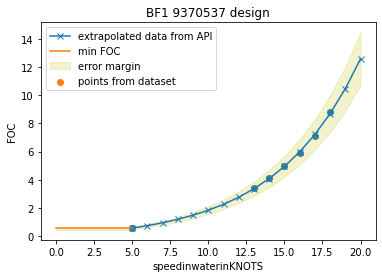


------------------------

0.36332631421866474 0.1797210878361035 -0.3097020429149245
total datapoints: 0
accepted datapoints: 0
Min FOC: 0.5636076458933519


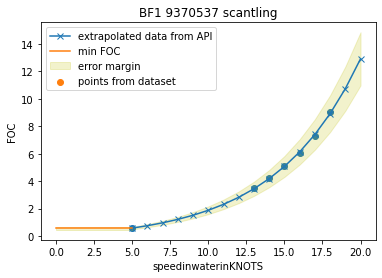


------------------------

0.42542247851327336 0.16487376552585803 -0.4129288230799722
total datapoints: 11
accepted datapoints: 10
Min FOC: 0.5636076458933519


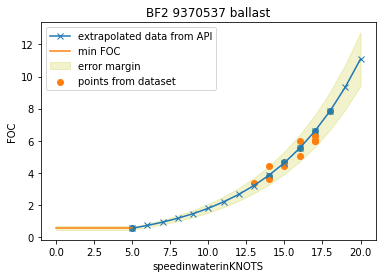


------------------------

0.37038930201193593 0.17774259532003472 -0.3183704906916819
total datapoints: 9
accepted datapoints: 4
Min FOC: 0.5636076458933519


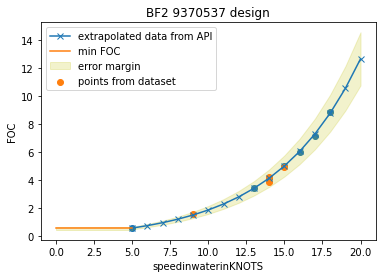


------------------------

0.3789673819478971 0.17797109908391745 -0.33919511017423226
total datapoints: 4
accepted datapoints: 3
Min FOC: 0.5636076458933519


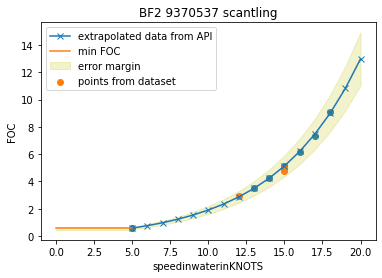


------------------------

0.5112173763434368 0.1575877446329069 -0.5646046634609676
total datapoints: 88
accepted datapoints: 65
Min FOC: 0.5636076458933519


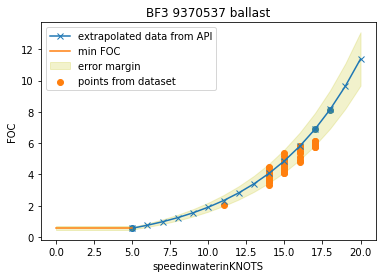


------------------------

0.45464599496589914 0.16932983843486965 -0.47405264247067674
total datapoints: 68
accepted datapoints: 54
Min FOC: 0.5636076458933519


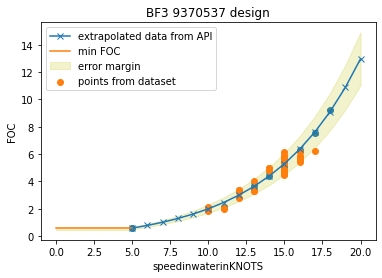


------------------------

0.4622793583400818 0.16984161383344526 -0.49350164137731484
total datapoints: 36
accepted datapoints: 24
Min FOC: 0.5636076458933519


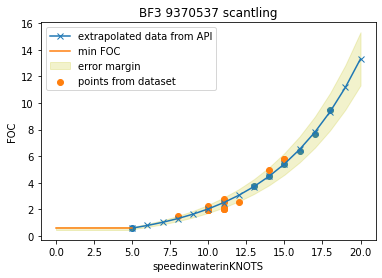


------------------------

0.6836867108544711 0.14644671366193335 -0.8604981443656397
total datapoints: 220
accepted datapoints: 174
Min FOC: 0.5636076458933519


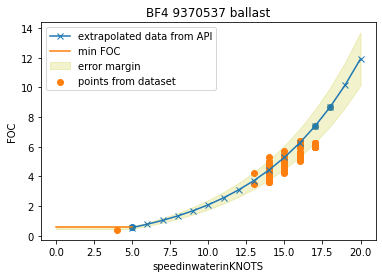


------------------------

0.6215768443708237 0.15689962741645605 -0.770718817508175
total datapoints: 157
accepted datapoints: 102
Min FOC: 0.5636076458933519


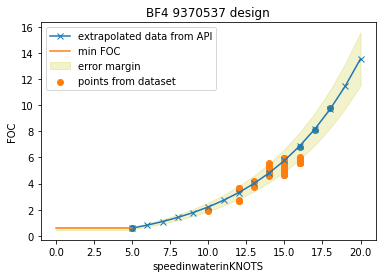


------------------------

0.6286816558049811 0.1576089909379663 -0.7899290586537167
total datapoints: 124
accepted datapoints: 110
Min FOC: 0.5636076458933519


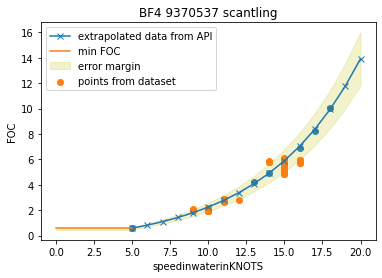


------------------------

1.1947948464381954 0.12609697696178893 -1.680001763812177
total datapoints: 336
accepted datapoints: 118
Min FOC: 0.5636076458933519


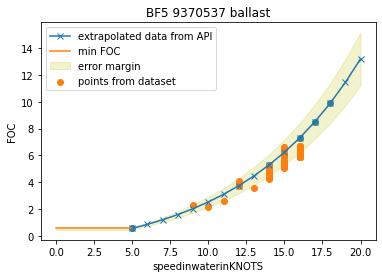


------------------------

1.1542483882167687 0.1333615431250234 -1.653192008167663
total datapoints: 391
accepted datapoints: 119
Min FOC: 0.5636076458933519


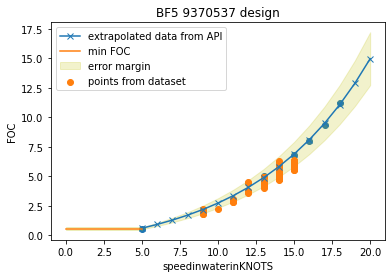


------------------------

1.1595189969032214 0.1342887939932336 -1.6733068049862705
total datapoints: 334
accepted datapoints: 172
Min FOC: 0.5636076458933519


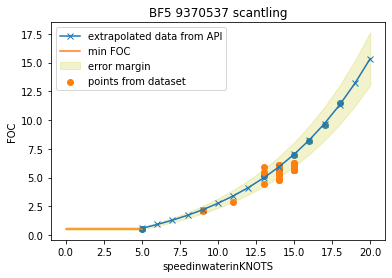


------------------------

0.07871053408298288 0.25981934608494456 0.6584895729067317
total datapoints: 0
accepted datapoints: 0
Min FOC: 0.3516793334279281


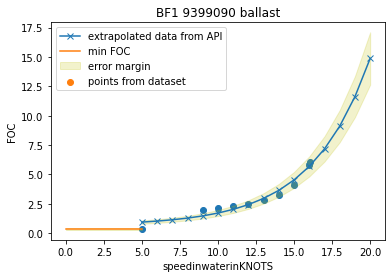


------------------------

0.30173169706926617 0.19290071856723257 -0.1360605087617736
total datapoints: 1
accepted datapoints: 0
Min FOC: 0.3516793334279281


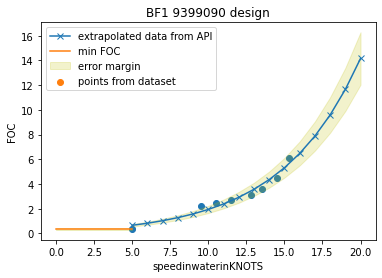


------------------------

0.5531272849336669 0.16485929736809002 -0.6287457509848702
total datapoints: 0
accepted datapoints: 0
Min FOC: 0.3516793334279281


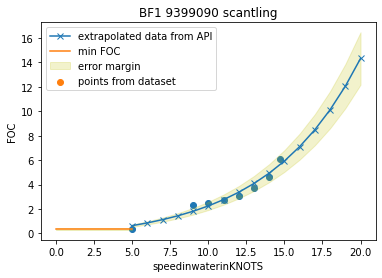


------------------------

0.08258887002380876 0.25743661284577307 0.6509494954485096
total datapoints: 12
accepted datapoints: 6
Min FOC: 0.3516793334279281


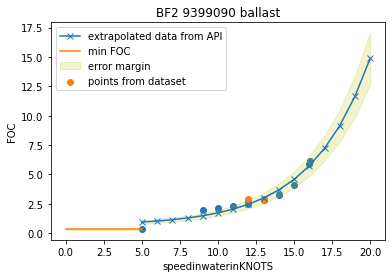


------------------------

0.3153662236578513 0.19087766676778897 -0.16296171523756356
total datapoints: 12
accepted datapoints: 5
Min FOC: 0.3516793334279281


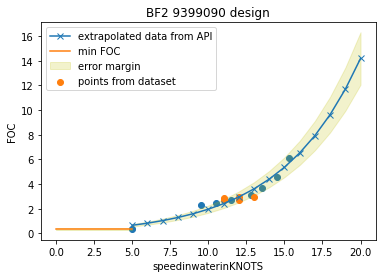


------------------------

0.5749366765107353 0.1631897865952429 -0.6669365014779122
total datapoints: 6
accepted datapoints: 4
Min FOC: 0.3516793334279281


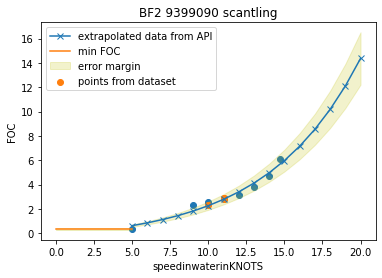


------------------------

0.10329499638551033 0.2465382496543688 0.6116711622658242
total datapoints: 11
accepted datapoints: 10
Min FOC: 0.3516793334279281


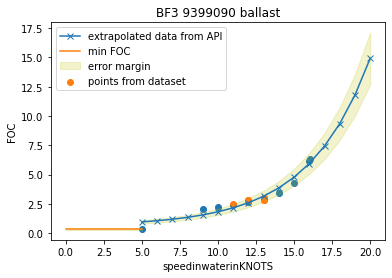


------------------------

0.3861200030996291 0.18186606094293387 -0.29911932021095194
total datapoints: 65
accepted datapoints: 29
Min FOC: 0.3516793334279281


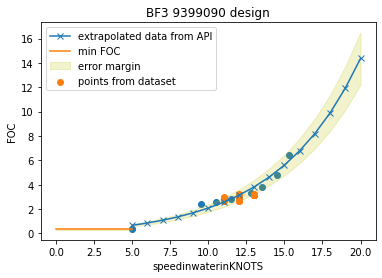


------------------------

0.6866112055259248 0.15578002546632114 -0.859108987484463
total datapoints: 97
accepted datapoints: 62
Min FOC: 0.3516793334279281


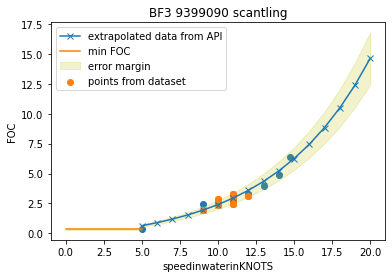


------------------------

0.14820228581427533 0.22929904476473034 0.5200794904122504
total datapoints: 48
accepted datapoints: 23
Min FOC: 0.3516793334279281


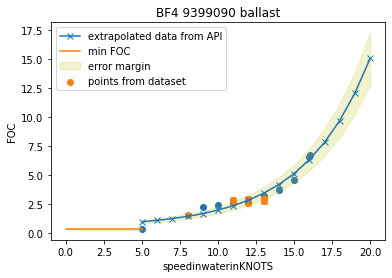


------------------------

0.5200695445207096 0.16928022840354612 -0.54585343546679
total datapoints: 159
accepted datapoints: 59
Min FOC: 0.3516793334279281


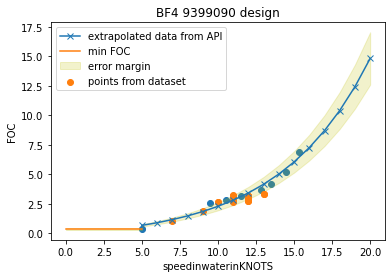


------------------------

0.9028256330055864 0.14482488022720572 -1.218916977402545
total datapoints: 179
accepted datapoints: 109
Min FOC: 0.3516793334279281


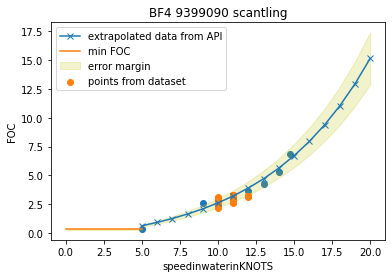


------------------------

0.28814770259665434 0.1993896999231299 0.24475172869507925
total datapoints: 146
accepted datapoints: 58
Min FOC: 0.3516793334279281


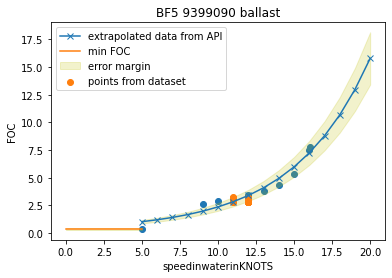


------------------------

0.8955312173958151 0.1484126969967152 -1.1989013125766377
total datapoints: 439
accepted datapoints: 131
Min FOC: 0.3516793334279281


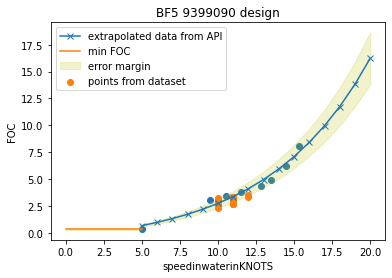


------------------------

1.4731871999781803 0.12756407142051046 -2.1290299255331138
total datapoints: 560
accepted datapoints: 159
Min FOC: 0.3516793334279281


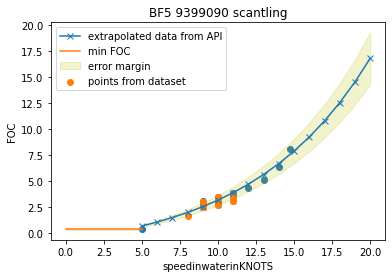


------------------------

0.10947702697338865 0.25336651061722526 0.21376691939262105
total datapoints: 0
accepted datapoints: 0
Min FOC: 0.4182829176874004


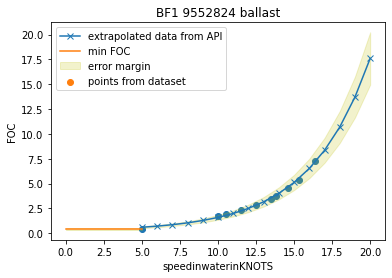


------------------------

0.1037417711398388 0.287382822053773 0.08412533280729051
total datapoints: 0
accepted datapoints: 0
Min FOC: 0.4182829176874004


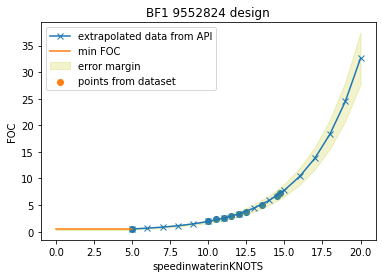


------------------------

0.1037417711398388 0.287382822053773 0.08412533280729051
total datapoints: 4
accepted datapoints: 2
Min FOC: 0.4182829176874004


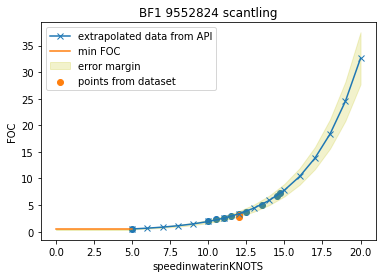


------------------------

0.11370221311977706 0.25157392216938596 0.20885225106751512
total datapoints: 0
accepted datapoints: 0
Min FOC: 0.4182829176874004


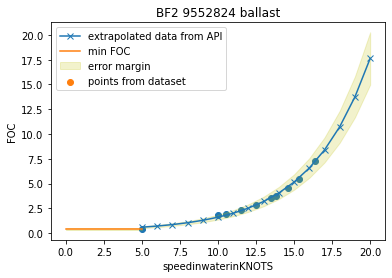


------------------------

0.10882620552515805 0.28483515908279144 0.07230285349712065
total datapoints: 4
accepted datapoints: 2
Min FOC: 0.4182829176874004


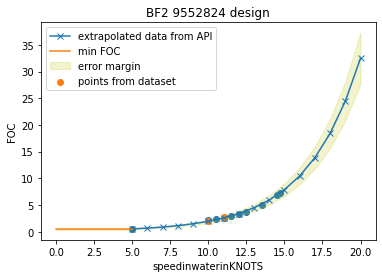


------------------------

0.10882620552515805 0.28483515908279144 0.07230285349712065
total datapoints: 34
accepted datapoints: 23
Min FOC: 0.4182829176874004


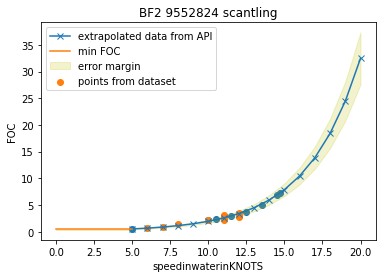


------------------------

0.1412832767080045 0.24097872672165893 0.16480185651167825
total datapoints: 1
accepted datapoints: 0
Min FOC: 0.4182829176874004


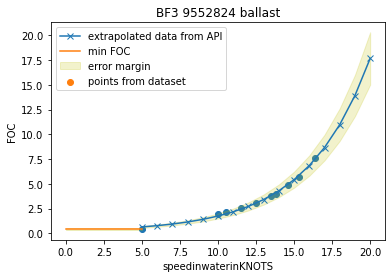


------------------------

0.13883577876525657 0.2718419745098641 0.000636330535293103
total datapoints: 118
accepted datapoints: 56
Min FOC: 0.4182829176874004


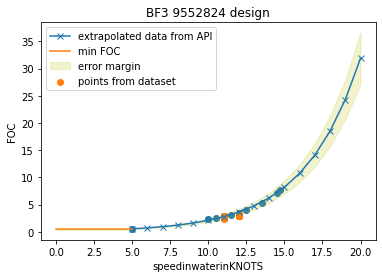


------------------------

0.13883577876525657 0.2718419745098641 0.000636330535293103
total datapoints: 41
accepted datapoints: 25
Min FOC: 0.4182829176874004


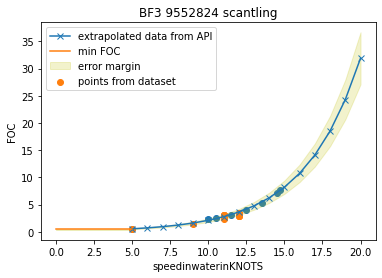


------------------------

0.19905005962201858 0.22456754325635409 0.06338221057171803
total datapoints: 0
accepted datapoints: 0
Min FOC: 0.4182829176874004


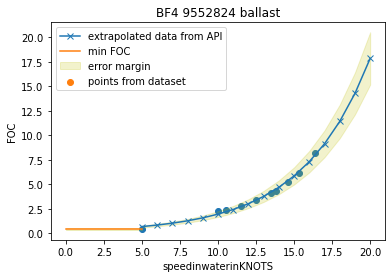


------------------------

0.20156770457513123 0.2525054839380843 -0.14979290242327073
total datapoints: 239
accepted datapoints: 38
Min FOC: 0.4182829176874004


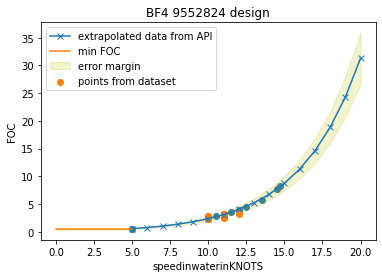


------------------------

0.20156770457513123 0.2525054839380843 -0.14979290242327073
total datapoints: 151
accepted datapoints: 97
Min FOC: 0.4182829176874004


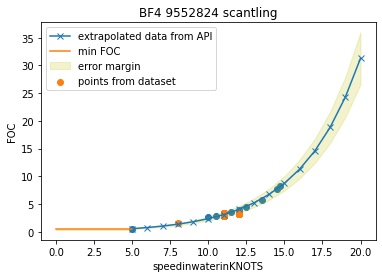


------------------------

0.38864067673256614 0.1943440688223799 -0.28798636413531375
total datapoints: 0
accepted datapoints: 0
Min FOC: 0.4182829176874004


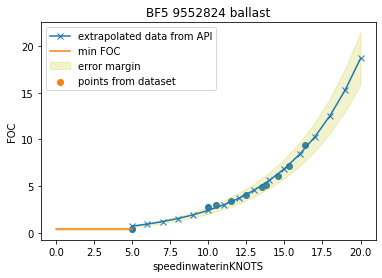


------------------------

0.41328556207127615 0.21716110217367113 -0.6348065754534807
total datapoints: 416
accepted datapoints: 30
Min FOC: 0.4182829176874004


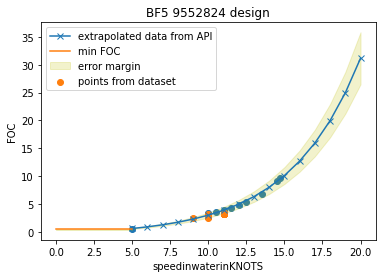


------------------------

0.41328556207127615 0.21716110217367113 -0.6348065754534807
total datapoints: 651
accepted datapoints: 233
Min FOC: 0.4182829176874004


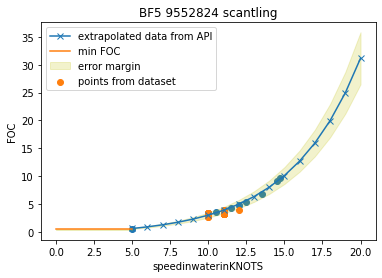


------------------------

0.10947702697338865 0.25336651061722526 0.21376691939262105
total datapoints: 0
accepted datapoints: 0
Min FOC: 0.4182829176874004


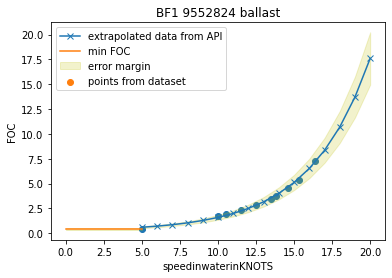


------------------------

0.1037417711398388 0.287382822053773 0.08412533280729051
total datapoints: 0
accepted datapoints: 0
Min FOC: 0.4182829176874004


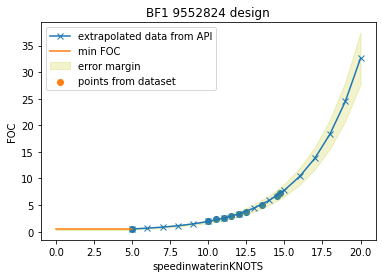


------------------------

0.1037417711398388 0.287382822053773 0.08412533280729051
total datapoints: 4
accepted datapoints: 2
Min FOC: 0.4182829176874004


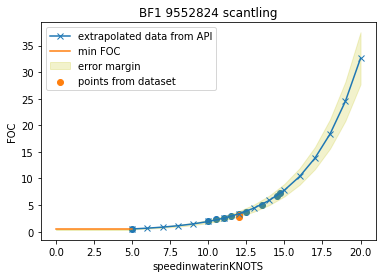


------------------------

0.11370221311977706 0.25157392216938596 0.20885225106751512
total datapoints: 0
accepted datapoints: 0
Min FOC: 0.4182829176874004


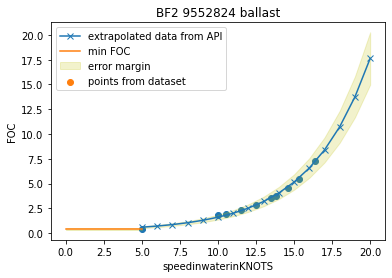


------------------------

0.10882620552515805 0.28483515908279144 0.07230285349712065
total datapoints: 4
accepted datapoints: 2
Min FOC: 0.4182829176874004


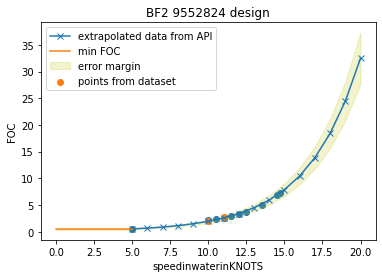


------------------------

0.10882620552515805 0.28483515908279144 0.07230285349712065
total datapoints: 34
accepted datapoints: 23
Min FOC: 0.4182829176874004


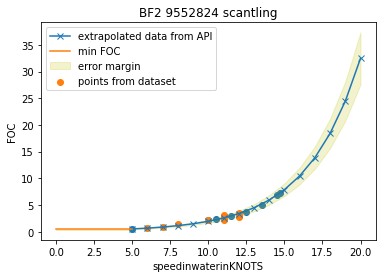


------------------------

0.1412832767080045 0.24097872672165893 0.16480185651167825
total datapoints: 1
accepted datapoints: 0
Min FOC: 0.4182829176874004


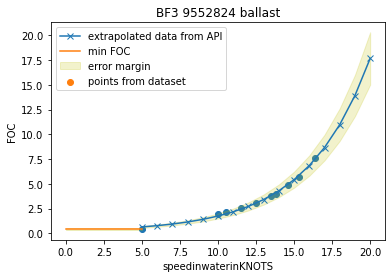


------------------------

0.13883577876525657 0.2718419745098641 0.000636330535293103
total datapoints: 118
accepted datapoints: 56
Min FOC: 0.4182829176874004


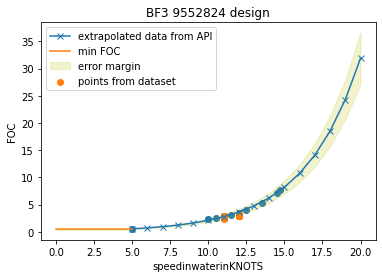


------------------------

0.13883577876525657 0.2718419745098641 0.000636330535293103
total datapoints: 41
accepted datapoints: 25
Min FOC: 0.4182829176874004


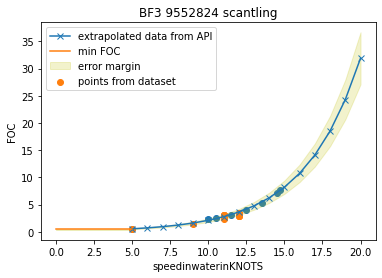


------------------------

0.19905005962201858 0.22456754325635409 0.06338221057171803
total datapoints: 0
accepted datapoints: 0
Min FOC: 0.4182829176874004


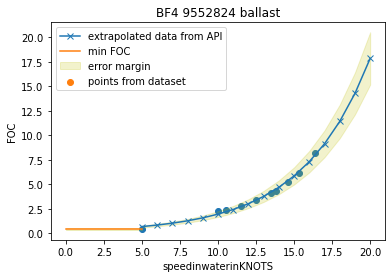


------------------------

0.20156770457513123 0.2525054839380843 -0.14979290242327073
total datapoints: 239
accepted datapoints: 38
Min FOC: 0.4182829176874004


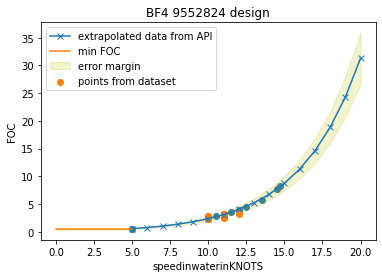


------------------------

0.20156770457513123 0.2525054839380843 -0.14979290242327073
total datapoints: 151
accepted datapoints: 97
Min FOC: 0.4182829176874004


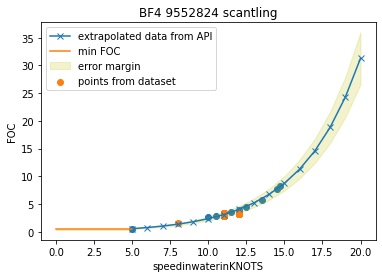


------------------------

0.38864067673256614 0.1943440688223799 -0.28798636413531375
total datapoints: 0
accepted datapoints: 0
Min FOC: 0.4182829176874004


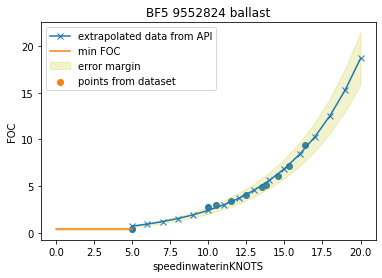


------------------------

0.41328556207127615 0.21716110217367113 -0.6348065754534807
total datapoints: 416
accepted datapoints: 30
Min FOC: 0.4182829176874004


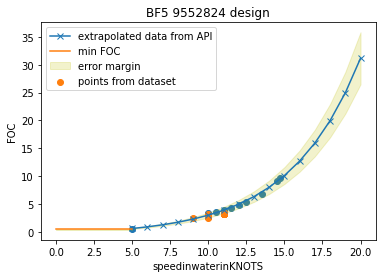


------------------------

0.41328556207127615 0.21716110217367113 -0.6348065754534807
total datapoints: 651
accepted datapoints: 233
Min FOC: 0.4182829176874004


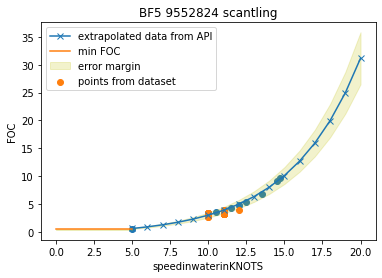


------------------------

0.20050153090438394 0.23077041004236012 0.44821328985394904
total datapoints: 4
accepted datapoints: 1
Min FOC: 0.6235530792068474


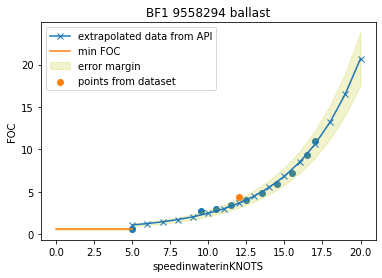


------------------------

0.630021483158167 0.17492489634712716 -0.6857433608566703
total datapoints: 6
accepted datapoints: 2
Min FOC: 0.6235530792068474


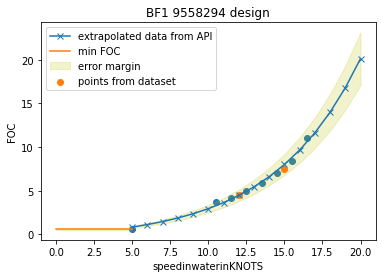


------------------------

0.7217397528564333 0.1709493204085338 -0.9070681647502846
total datapoints: 5
accepted datapoints: 3
Min FOC: 0.6235530792068474


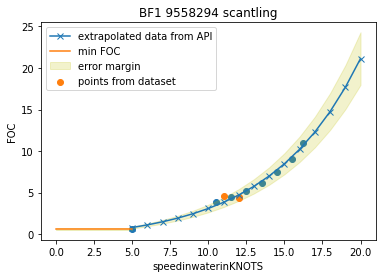


------------------------

0.2076623260861116 0.22916185598229463 0.4389218988862062
total datapoints: 22
accepted datapoints: 15
Min FOC: 0.6235530792068474


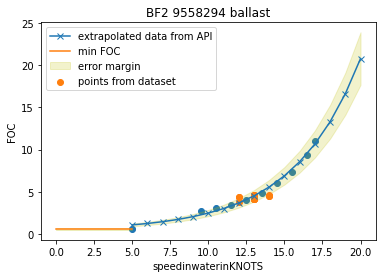


------------------------

0.6501631353255222 0.1736524383189452 -0.7211968195786623
total datapoints: 60
accepted datapoints: 23
Min FOC: 0.6235530792068474


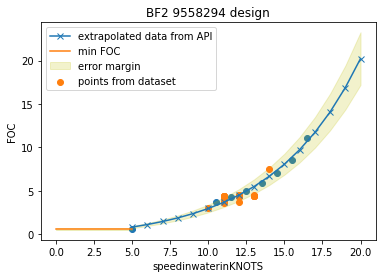


------------------------

0.7429973330389174 0.16981049998788406 -0.9443133467386401
total datapoints: 30
accepted datapoints: 18
Min FOC: 0.6235530792068474


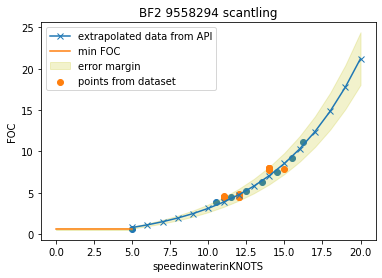


------------------------

0.24404673986927908 0.22184475288078617 0.39054967235318266
total datapoints: 65
accepted datapoints: 25
Min FOC: 0.6235530792068474


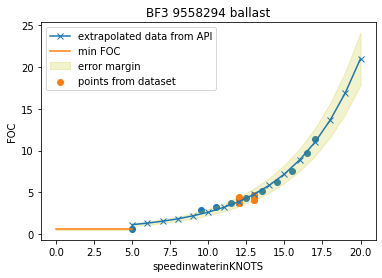


------------------------

0.7534183037125567 0.16781857041923492 -0.900873451719166
total datapoints: 196
accepted datapoints: 80
Min FOC: 0.6235530792068474


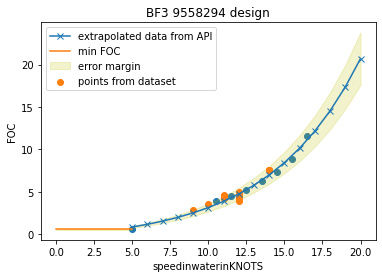


------------------------

0.8506218557835636 0.1646732782557218 -1.1315183767211638
total datapoints: 155
accepted datapoints: 61
Min FOC: 0.6235530792068474


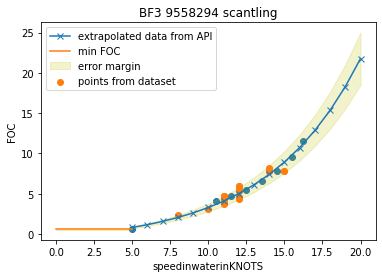


------------------------

0.3148853293510006 0.21059372029411308 0.2925586411710297
total datapoints: 48
accepted datapoints: 11
Min FOC: 0.6235530792068474


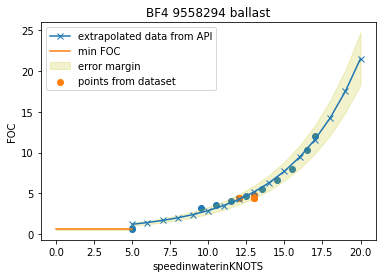


------------------------

0.9409941728676872 0.1595379168184681 -1.2235582287333762
total datapoints: 235
accepted datapoints: 90
Min FOC: 0.6235530792068474


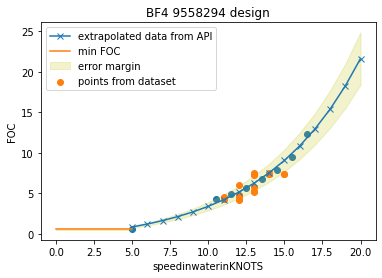


------------------------

1.0546810379808633 0.1567759897386512 -1.4830134456000565
total datapoints: 154
accepted datapoints: 49
Min FOC: 0.6235530792068474


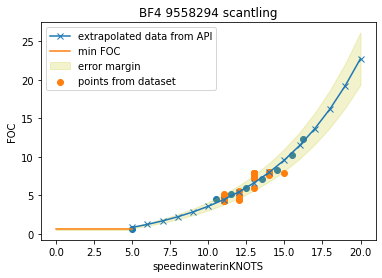


------------------------

0.5174999808645128 0.18966760377099068 -0.021253538328796753
total datapoints: 43
accepted datapoints: 5
Min FOC: 0.6235530792068474


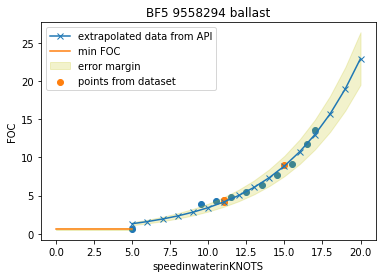


------------------------

1.416547990985625 0.14584896872661413 -2.031038047057679
total datapoints: 656
accepted datapoints: 220
Min FOC: 0.6235530792068474


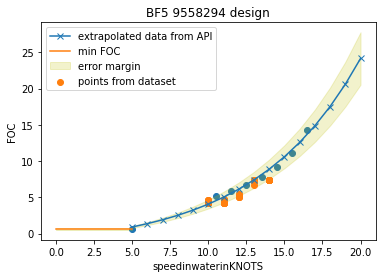


------------------------

1.568520982188907 0.14367260967559886 -2.354086581366407
total datapoints: 604
accepted datapoints: 319
Min FOC: 0.6235530792068474


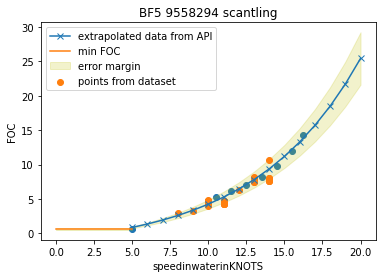


------------------------

0.13587447252763776 0.22748639567049186 0.18849913425408668
total datapoints: 0
accepted datapoints: 0
Min FOC: 0.34902147817676593


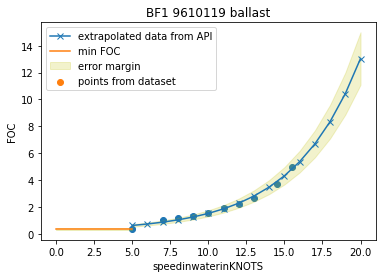


------------------------

0.17507646646249758 0.21991586745640732 0.17132722445652057
total datapoints: 2
accepted datapoints: 0
Min FOC: 0.34902147817676593


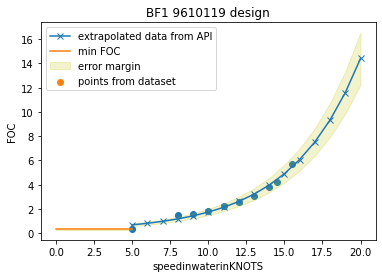


------------------------

0.4641142535772688 0.16530990079705113 -0.4214271513541195
total datapoints: 1
accepted datapoints: 0
Min FOC: 0.34902147817676593


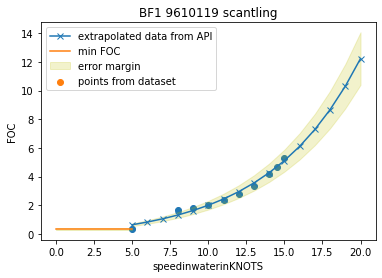


------------------------

0.1429176838246453 0.22482073774675196 0.17856031111892517
total datapoints: 0
accepted datapoints: 0
Min FOC: 0.34902147817676593


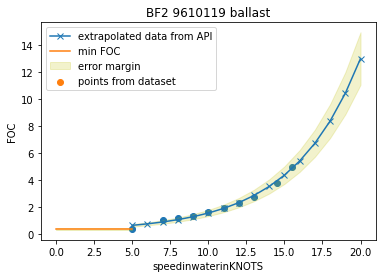


------------------------

0.18472165150667816 0.21723165685549586 0.15293634561124028
total datapoints: 21
accepted datapoints: 11
Min FOC: 0.34902147817676593


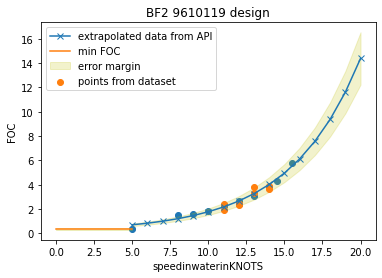


------------------------

0.48878290599084717 0.1629037919341935 -0.462356869226352
total datapoints: 20
accepted datapoints: 11
Min FOC: 0.34902147817676593


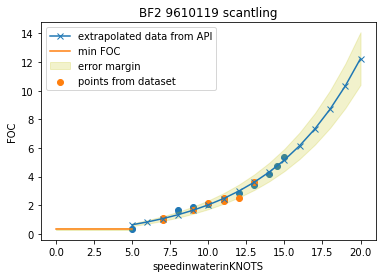


------------------------

0.1828851342226441 0.21193930521432008 0.12030708835687473
total datapoints: 17
accepted datapoints: 15
Min FOC: 0.34902147817676593


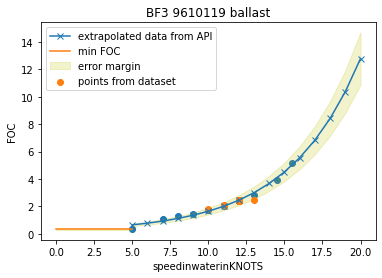


------------------------

0.23883112076295113 0.2046093916911545 0.05203980023089112
total datapoints: 61
accepted datapoints: 45
Min FOC: 0.34902147817676593


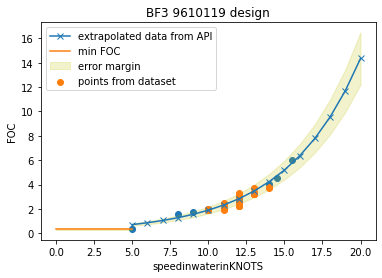


------------------------

0.6266955430912374 0.1516170475715842 -0.6857224631331629
total datapoints: 177
accepted datapoints: 140
Min FOC: 0.34902147817676593


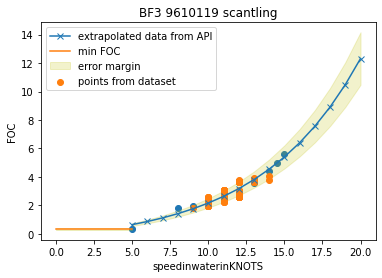


------------------------

0.2616766103701073 0.19411865937210326 0.008310373275873804
total datapoints: 29
accepted datapoints: 20
Min FOC: 0.34902147817676593


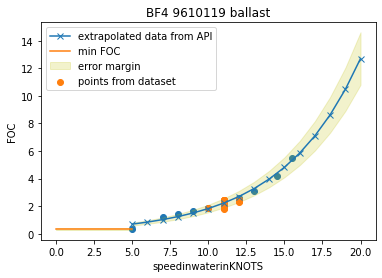


------------------------

0.35002703514114747 0.18653616591237324 -0.14564717684893216
total datapoints: 198
accepted datapoints: 122
Min FOC: 0.34902147817676593


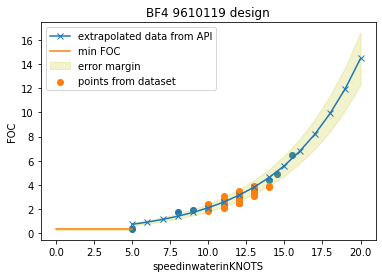


------------------------

0.9115286219689513 0.1355082026671919 -1.1274618621316188
total datapoints: 299
accepted datapoints: 237
Min FOC: 0.34902147817676593


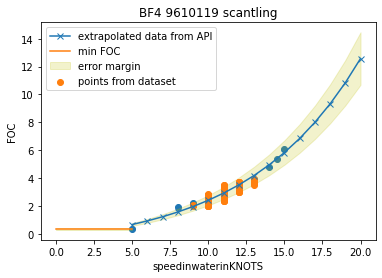


------------------------

0.5074720067546642 0.16352885460268715 -0.33831517127937666
total datapoints: 82
accepted datapoints: 21
Min FOC: 0.34902147817676593


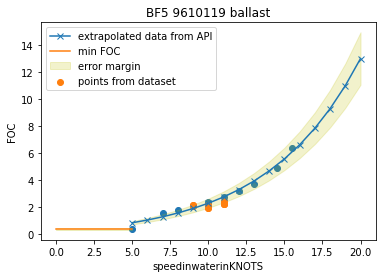


------------------------

0.704915397623054 0.15611181274204283 -0.7428651259732253
total datapoints: 565
accepted datapoints: 141
Min FOC: 0.34902147817676593


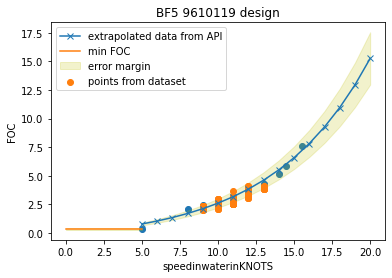


------------------------

1.6826901992360548 0.11292171874768422 -2.2530480410585536
total datapoints: 424
accepted datapoints: 210
Min FOC: 0.34902147817676593


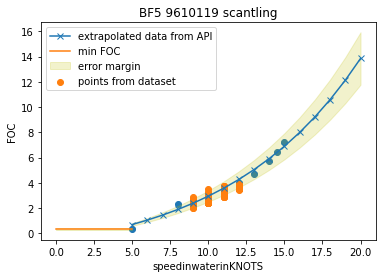

No of elements in dict:  90
Elements plotted:  90


In [15]:
combined_df = autoplotter(XX)

In [16]:
combined_df.head()

,Unnamed: 0,voyageid,noonreportid,vesselid,lat,long,fuelconsumedbymainengineintons,averagespeedongroundinknots,averagespeedonwaterinknots,displacement,...,recordeddateinutc,oceancurrentspeed,oceancurrentdirection,bearing,bearing_360,averagespeedongroundinmps,averagespeedonwaterinmps,windvelocity,wavevelocity,accepted
121,20,v2,b88b9000-a45d-11eb-8080-808080808080,9370537,1.340017,104.356350,3.25,13.36,13,37510.0,...,2021-04-23T18:00:00Z,0.09,198.43,-105.134552,254.865448,6.872428,6.922187,-0.399727,-0.037549,1.0
22,1,v1,32ac4800-a609-11eb-8080-808080808080,9370537,1.817767,102.513117,5.07,16.94,16,38594.0,...,2021-04-25T21:00:00Z,0.70,180.00,-53.646190,306.353810,8.713992,8.299053,2.311791,-0.059987,1.0
23,2,v1,57f98000-a622-11eb-8080-808080808080,9370537,2.291633,101.868617,6.01,16.09,16,38594.0,...,2021-04-26T00:00:00Z,0.01,103.72,-57.712612,302.287388,8.276749,8.267269,0.553336,-0.068893,1.0
24,3,v1,7d46b800-a63b-11eb-8080-808080808080,9370537,2.759650,101.126750,6.28,17.61,17,38594.0,...,2021-04-26T03:00:00Z,0.05,166.16,-48.126571,311.873429,9.058642,9.017330,0.987667,-0.169990,1.0
25,4,v1,a293f000-a654-11eb-8080-808080808080,9370537,3.349400,100.467517,6.01,17.83,17,38594.0,...,2021-04-26T06:00:00Z,0.04,145.03,-47.178215,312.821785,9.171811,9.132715,1.602501,-0.046598,1.0


In [17]:
df_9735050 = combined_df[combined_df['vesselid'] == 9735050]
df_9746695 = combined_df[combined_df['vesselid'] == 9746695]
df_9788564 = combined_df[combined_df['vesselid'] == 9788564]
df_9792515 = combined_df[combined_df['vesselid'] == 9792515]
df_9796585 = combined_df[combined_df['vesselid'] == 9796585]
df_9803364 = combined_df[combined_df['vesselid'] == 9803364]

accepted_shipDF_list = [df_9735050, df_9746695, df_9788564, df_9792515, df_9796585, df_9803364]
for i in accepted_shipDF_list:
    print(len(i.index))

0
0
0
0
0
0


In [18]:
for vessel_id in combined_df['vesselid'].unique():
    df_removed = combined_df[combined_df['vesselid'] == vessel_id]
    df_original = pd.read_csv('C:/Users/hengj/Downloads/training_data/'+str(vessel_id)+'_complete.csv')
    print('No of datapoints for VESSEL', vessel_id)
    print('Original dataframe:', df_original.shape[0])
    print('After removal:', df_removed.shape[0])
    print('\n')
    

No of datapoints for VESSEL 9370537
Original dataframe: 3046
After removal: 956


No of datapoints for VESSEL 9399090
Original dataframe: 2747
After removal: 655


No of datapoints for VESSEL 9552824
Original dataframe: 2223
After removal: 1012


No of datapoints for VESSEL 9558294
Original dataframe: 3563
After removal: 922


No of datapoints for VESSEL 9610119
Original dataframe: 3292
After removal: 973




In [19]:
def XGBModel(X_train: pd.DataFrame, y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame):
    xg = XGBRegressor(n_estimators=1000, enable_categorical = True)
    xg.fit(X_train,y_train)
    y_train_pred = xg.predict(X_train)
    y_test_pred = xg.predict(X_test)
#     f, axes = plt.subplots(1, 2, figsize=(24, 12))
#     axes[0].scatter(y_train, y_train_pred, color = "blue")
#     axes[0].plot(y_train, y_train, 'w-', linewidth = 1)
#     axes[0].set_xlabel("True values of the Response Variable (Train)")
#     axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
#     axes[1].scatter(y_test, y_test_pred, color = "green")
#     axes[1].plot(y_test, y_test, 'w-', linewidth = 1)
#     axes[1].set_xlabel("True values of the Response Variable (Test)")
#     axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
#     plt.show()
    # Check the Goodness of Fit (on Train Data)
    print("Goodness of Fit of Model \tTrain Dataset")
    print("Explained Variance (R^2) \t:", xg.score(X_train, y_train))
    print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
    print("Root Mean Squared Error (RMSE) \t:", math.sqrt(mean_squared_error(y_train, y_train_pred)))
    print()

    # Check the Goodness of Fit (on Test Data)
    print("Goodness of Fit of Model \tTest Dataset")
    print("Explained Variance (R^2) \t:", xg.score(X_test, y_test))
    print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
    print("Root Mean Squared Error (RMSE) \t:", math.sqrt(mean_squared_error(y_test, y_test_pred)))
    print()
    
#     # Get numerical feature importances
#     importances = list(xg.feature_importances_)
#     # List of tuples with variable and importance
#     feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(X, importances)]
#     # Sort the feature importances by most important first
#     feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
#     # Print out the feature and importances 
#     [print('Variable: {} \t Importance: {}'.format(*pair)) for pair in feature_importances];
    
#     return xg.score(X_train, y_train), xg.score(X_test, y_test)

def RandomForestModel(X_train: pd.DataFrame, y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame):
    rf = RandomForestRegressor(n_estimators = 1000) #optional to set random_state
    rf.fit(X_train,y_train)
    
    y_train_pred = rf.predict(X_train)
    y_test_pred = rf.predict(X_test)

    # Plot the Predictions vs the True values
#     f, axes = plt.subplots(1, 2, figsize=(24, 12))
#     axes[0].scatter(y_train, y_train_pred, color = "blue")
#     axes[0].plot(y_train, y_train, 'w-', linewidth = 1)
#     axes[0].set_xlabel("True values of the Response Variable (Train)")
#     axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
#     axes[1].scatter(y_test, y_test_pred, color = "green")
#     axes[1].plot(y_test, y_test, 'w-', linewidth = 1)
#     axes[1].set_xlabel("True values of the Response Variable (Test)")
#     axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
#     plt.show()
    
    # Check the Goodness of Fit (on Train Data)
    print("Goodness of Fit of Model \tTrain Dataset")
    print("Explained Variance (R^2) \t:", rf.score(X_train, y_train))
    print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
    print("Root Mean Squared Error (RMSE) \t:", math.sqrt(mean_squared_error(y_train, y_train_pred)))
    print()

    # Check the Goodness of Fit (on Test Data)
    print("Goodness of Fit of Model \tTest Dataset")
    print("Explained Variance (R^2) \t:", rf.score(X_test, y_test))
    print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
    print("Root Mean Squared Error (RMSE) \t:", math.sqrt(mean_squared_error(y_test, y_test_pred)))
    print()
    
#     # Get numerical feature importances
#     importances = list(rf.feature_importances_)
#     # List of tuples with variable and importance
#     feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(X, importances)]
#     # Sort the feature importances by most important first
#     feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
#     # Print out the feature and importances 
#     [print('Variable: {} \t Importance: {}'.format(*pair)) for pair in feature_importances];
    
#     return rf.score(X_train, y_train), rf.score(X_test, y_test)

In [20]:
for vessel_id in combined_df['vesselid'].unique():
    df_removed = combined_df[combined_df['vesselid'] == vessel_id]
    y = df_removed['fuelconsumedbymainengineintons']
    X = df_removed[['averagespeedonwaterinmps', # use average speed on water in mps
                               'displacement',
                               #'steamingtime',
                               'wavedirection',
                               'waveheightinmeters',
                               #'wavevelocity',
                               'windvelocity',
                               #'wind_angle_of_attack',
                               #'windforce',
                               #'windspeedinmps'
                            ]]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=90210)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    XGBModel(X_train_scaled, y_train, X_test_scaled, y_test)
    RandomForestModel(X_train_scaled, y_train, X_test_scaled, y_test)

[15:14:24] WARNING: ..\src\learner.cc:573: 
Parameters: { "enable_categorical" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.9999974291581216
Mean Squared Error (MSE) 	: 3.452461698610629e-06
Root Mean Squared Error (RMSE) 	: 0.0018580801109238077

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.938816902349157
Mean Squared Error (MSE) 	: 0.07437528695072654
Root Mean Squared Error (RMSE) 	: 0.2727183289599849

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.9927011168593806
Mean Squared Error (MSE) 	: 0.009801892017189527
Root Mean Squared Error (RMSE) 	: 0.09900450503481914

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.9516965377849708
Me

In [21]:
 [n for n in range(10) if n % 2]

[1, 3, 5, 7, 9]

In [22]:
datetime(1970, 1, 1).strftime('%Y-%d-%B')

'1970-01-January'